In [6]:
import sklearn as sk
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time

import scipy

from scipy.optimize import curve_fit


ValueError: Mountpoint must not contain a space.

In [7]:
def timer(func):
  start_time_sec = time.time()
  func()
  elapsed_time_sec = time.time() - start_time_sec
  return elapsed_time_sec

In [8]:
def add_laplace_noise(x, b):
    return x + np.random.laplace(scale=b, size=len(x))

def add_noise_to_col(df, col, b):
  noised_col = add_laplace_noise(df[col], b)
  df["noised_" + col] = noised_col.clip(lower=0)

def add_noise_to_array(array, b):
    return array + np.random.laplace(scale=b, size=array.shape)


In [17]:
try:
    aisles_df = pd.read_csv('aisles.csv')
    departments_df = pd.read_csv('departments.csv')
    order_products_prior_df = pd.read_csv('order_products__train.csv')
    order_products_train_df = pd.read_csv('order_products__train.csv')
    orders_df = pd.read_csv('orders.csv')
    products_df = pd.read_csv('products.csv')
except:
    print('Files not available.')

In [10]:
# @title Table Info
print("----------------------------------------")
print("Aisles")
print(aisles_df.info())
print()

print("----------------------------------------")
print("Departments")
print(departments_df.info())
print()

print("----------------------------------------")
print("Products")
print(products_df.info())
print()

print("----------------------------------------")
print("Order Products Prior")
print(order_products_prior_df.info())
print()

print("----------------------------------------")
print("Order Products Train")
print(order_products_train_df.info())
print()

print("----------------------------------------")
print("Orders")
print(orders_df.info())
print()

print("----------------------------------------")

----------------------------------------
Aisles
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None

----------------------------------------
Departments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes
None

----------------------------------------
Products
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   pro

In [11]:
# @title Table Heads
print("----------------------------------------")
print("Aisles")
print(aisles_df.head())
print()

print("----------------------------------------")
print("Departments")
print(departments_df.head())
print()

print("----------------------------------------")
print("Products")
print(products_df.head())
print()

print("----------------------------------------")
print("Order Products Prior")
print(order_products_prior_df.head())
print()

print("----------------------------------------")
print("Order Products Train")
print(order_products_train_df.head())
print()

print("----------------------------------------")
print("Orders")
print(orders_df.head(1000))
print()

print("----------------------------------------")

----------------------------------------
Aisles
   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

----------------------------------------
Departments
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

----------------------------------------
Products
   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chil

In [19]:
def PRODUCT_COUNT_QUERY():

  product_counts = np.zeros(shape=(len(products_df)))
  total_products_count = np.sum(product_counts)
  product_reordered_counts = np.zeros(shape=(len(products_df)))

  def product_counter(row):
    product_id = row["product_id"]
    product_counts[product_id-1] += 1
    product_reordered_counts[product_id-1] += row["reordered"]

  order_products_prior_df.apply(product_counter, axis=1)

  print(product_counts)

  products_df["count"] = product_counts
  products_df["reordered_count"] = product_reordered_counts

  product_reordered_rates = np.divide(product_reordered_counts, product_counts)

  total_products_count = np.sum(product_counts)

  product_percentages = product_counts / total_products_count

  products_df["count"] = product_counts
  products_df["reordered_rate"] = product_reordered_rates
  products_df["relative_freq"] = product_percentages

def AISLE_COUNT_QUERY():

  product_counts = np.zeros(shape=(len(products_df)))
  total_products_count = np.sum(product_counts)
  
  aisle_counts = np.zeros(shape=(len(aisles_df)))
  aisle_reordered_counts = np.zeros(shape=(len(aisles_df)))

  def other_counter(row):

      aisle_id = row["aisle_id"]

      product_count = row["count"]
      product_reordered_count = row["reordered_count"]

      aisle_counts[aisle_id-1] += product_count
      aisle_reordered_counts[aisle_id-1] += product_reordered_count

  products_df.apply(other_counter, axis=1)

  aisle_reordered_rates = np.divide(aisle_reordered_counts, aisle_counts)

  aisle_percentages = aisle_counts / total_products_count


  aisles_df["count"] = aisle_counts
  aisles_df["reordered_rate"] = aisle_reordered_rates
  aisles_df["relative_freq"] = aisle_percentages

def DEPARTMENT_COUNT_QUERY():

  product_counts = np.zeros(shape=(len(products_df)))
  total_products_count = np.sum(product_counts)

  department_counts = np.zeros(shape=(len(departments_df)))
  department_reordered_counts = np.zeros(shape=(len(departments_df)))

  def other_counter(row):

      aisle_id = row["aisle_id"]
      department_id = row["department_id"]

      product_count = row["count"]
      product_reordered_count = row["reordered_count"]

      department_counts[department_id-1] += product_count
      department_reordered_counts[department_id-1] += product_reordered_count

  products_df.apply(other_counter, axis=1)
    
  department_reordered_rates = np.divide(department_reordered_counts, department_counts)

  department_percentages= department_counts / total_products_count

  
  departments_df["reordered_rate"] = department_reordered_rates
  departments_df["relative_freq"] = department_percentages


In [24]:
PRODUCT_COUNT_QUERY()
AISLE_COUNT_QUERY()
DEPARTMENT_COUNT_QUERY()

[76.  4.  6. ...  7.  1.  4.]


/var/folders/74/9sxmrlgd45x6gkk7pj1yjxbc0000gn/T/ipykernel_46946/2844123832.py:19: RuntimeWarning: invalid value encountered in divide
  product_reordered_rates = np.divide(product_reordered_counts, product_counts)
/var/folders/74/9sxmrlgd45x6gkk7pj1yjxbc0000gn/T/ipykernel_46946/2844123832.py:51: RuntimeWarning: divide by zero encountered in divide
  aisle_percentages = aisle_counts / total_products_count
/var/folders/74/9sxmrlgd45x6gkk7pj1yjxbc0000gn/T/ipykernel_46946/2844123832.py:79: RuntimeWarning: divide by zero encountered in divide
  department_percentages= department_counts / total_products_count


In [25]:
def epsilon(var, sen):
  return (var 
  / (2 * sen)) ** -2

In [26]:
var_rel_freq_departments = 0.05
var_rel_freq_aisles = 0.01

sen_rel_freq_departments = 1/(len(departments_df))
sen_rel_freq_aisles = 1/(len(aisles_df))

e_rel_freq_departments = epsilon(var_rel_freq_departments, sen_rel_freq_departments)
e_rel_freq_aisles = epsilon(var_rel_freq_aisles, sen_rel_freq_aisles)

b_rel_freq_departments = sen_rel_freq_departments/e_rel_freq_departments
b_rel_freq_aisles = sen_rel_freq_aisles/e_rel_freq_aisles

print(e_rel_freq_departments, b_rel_freq_departments)
print(e_rel_freq_aisles, b_rel_freq_aisles)

3.6281179138321993 0.013125
2.227667631989307 0.00335


In [27]:

top_reordered_df = departments_df.sort_values(by=['reordered_rate'], ascending=False)
i = top_reordered_df["count"].idxmin()

var_reorder_rate_departments = 0.001

sen_reorder_rate_departments = 1/(top_reordered_df["count"][i])

e_reorder_rate_departments = epsilon(var_reorder_rate_departments, sen_reorder_rate_departments)

b_reorder_rate_departments = sen_reorder_rate_departments/e_reorder_rate_departments


print(e_reorder_rate_departments, b_reorder_rate_departments)

KeyError: 'count'

In [18]:
var_time_count = 10

sen_time_count = 1

e_time_count = epsilon(var_time_count, sen_time_count)

b_time_count = sen_time_count / e_time_count


print(e_time_count, b_time_count)


0.04


In [19]:
var_bins = 1

sen_bins = 1

e_bins = epsilon(var_bins, sen_bins)

b_bins = sen_bins / e_bins

print(e_bins, b_bins)

4.0


In [21]:
def min_top_products_by_department(department_name, quantity):

  id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]

  df = products_df.query(f"department_id == {id}").sort_values(by=["relative_freq"], ascending=False).head(quantity)

  return min(df["count"])

min1 = min_top_products_by_department("dairy eggs", 10)
min2 = min_top_products_by_department("beverages", 10)
min3 = min_top_products_by_department("produce", 10)

m_freq_shown = min([min1, min2, min3])

var_reorder_rate_products = 0.0001

sen_reorder_rate_products = 1/m_freq_shown

e_reorder_rate_products = epsilon(var_reorder_rate_products, sen_reorder_rate_products)

b_reorder_rate_products = var_reorder_rate_products / e_reorder_rate_products

print(e_reorder_rate_products, b_reorder_rate_products)


0.6442191468359747


In [28]:
e_rel_freq_departments + e_rel_freq_aisles + e_reorder_rate_departments + e_reorder_rate_departments + e_time_count + e_bins + e_reorder_rate_products

10.54669761605865

In [38]:
add_noise_to_col(products_df, "reordered_rate", b_reorder_rate_products)
add_noise_to_col(products_df, "relative_freq", 0.0005)
products_df["noised_relative_freq"] /= sum(products_df["noised_relative_freq"])

add_noise_to_col(aisles_df, "reordered_rate", 0.005)
add_noise_to_col(aisles_df, "relative_freq", b_rel_freq_aisles)
aisles_df["noised_relative_freq"] /= sum(aisles_df["noised_relative_freq"])

add_noise_to_col(departments_df, "reordered_rate", b_reorder_rate_departments)
add_noise_to_col(departments_df, "relative_freq", b_rel_freq_departments)
departments_df["noised_relative_freq"] /= sum(departments_df["noised_relative_freq"])

In [39]:
sum(departments_df["noised_relative_freq"])

1.0

In [40]:
departments_df.sort_values(by=["relative_freq"], ascending=False).head()

,department_id,department,count,reordered_rate,relative_freq,noised_reordered_rate,noised_relative_freq
3,4,produce,9479291.0,0.649913,0.292260,0.644904,0.271022
15,16,dairy eggs,5414016.0,0.669969,0.166922,0.668984,0.145563
18,19,snacks,2887550.0,0.574180,0.089027,0.581156,0.104991
6,7,beverages,2690129.0,0.653460,0.082940,0.657081,0.108395
0,1,frozen,2236432.0,0.541885,0.068952,0.552631,0.112214


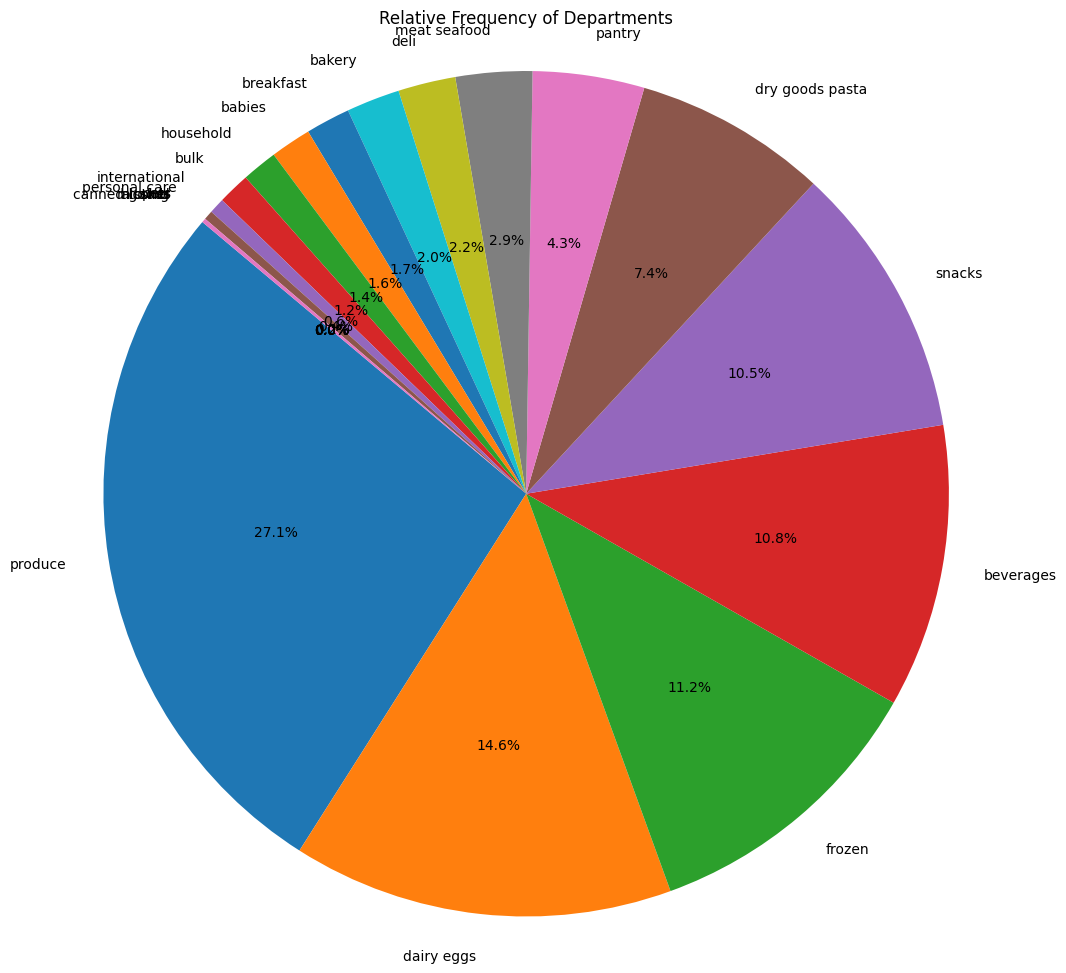

In [41]:
df = departments_df.sort_values(by=["noised_relative_freq"], ascending=False)

plt.figure(figsize=(12, 12))  # Optional: Adjust the figure size
plt.pie(df['noised_relative_freq'], labels=df['department'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Relative Frequency of Departments')

# Show plot
plt.show()

Text(0.5, 1.0, 'Highest Reorder Rate of Departments')

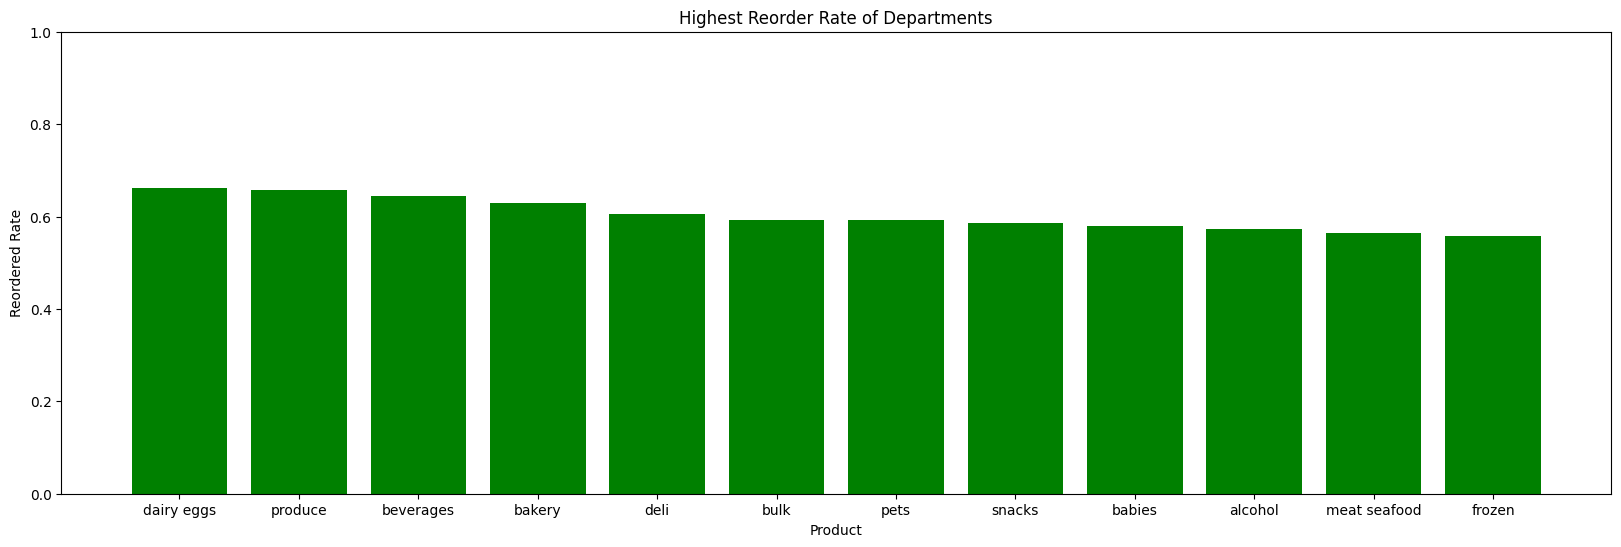

In [ ]:
df = departments_df.sort_values(by=['noised_reordered_rate'], ascending=False).head(12)

plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
plt.bar(df['department'], df['noised_reordered_rate'], color='green')

plt.ylim(0, 1)

# Adding labels and title
plt.xlabel('Product')
plt.ylabel('Reordered Rate')
plt.title('Highest Reorder Rate of Departments')

# Show plot

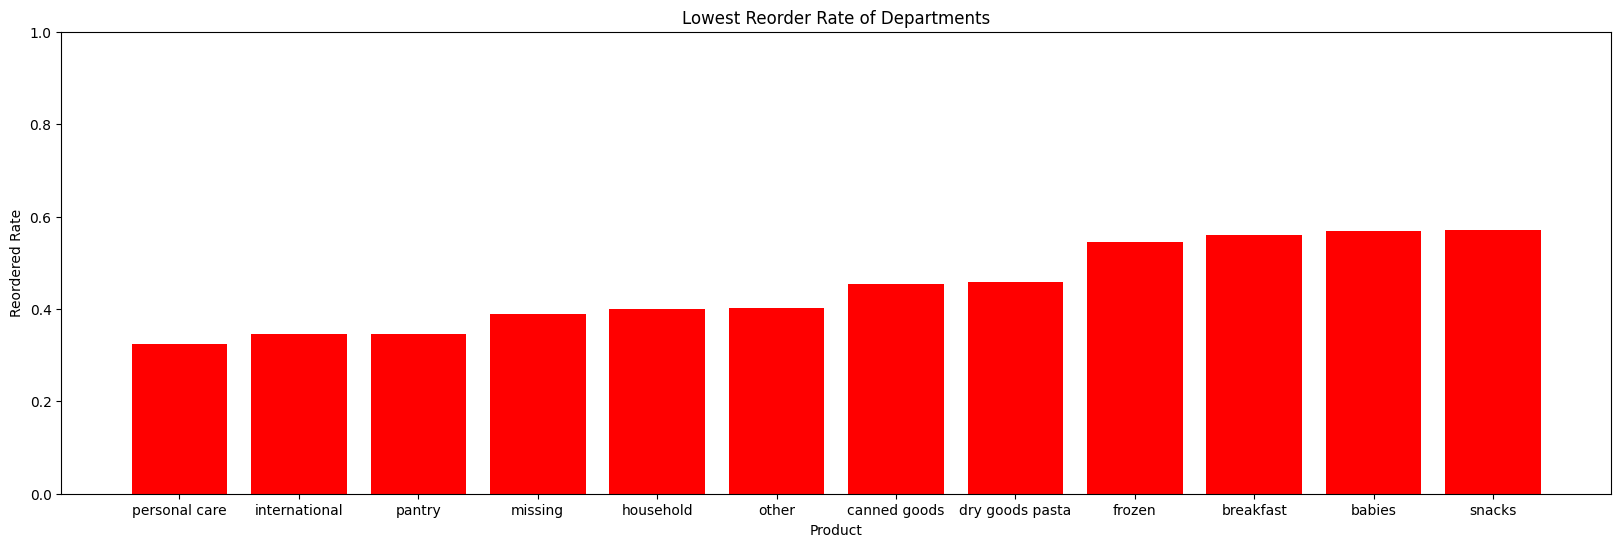

In [ ]:
df = departments_df.sort_values(by=['noised_reordered_rate'], ascending=True).head(12)

plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
plt.bar(df['department'], df['noised_reordered_rate'], color='red')

plt.ylim(0, 1)

# Adding labels and title
plt.xlabel('Product')
plt.ylabel('Reordered Rate')
plt.title('Lowest Reorder Rate of Departments')

# Show plot
plt.show()



In [ ]:
def time_heatmap(order_subset, b):

  time_table = np.zeros(shape=(7, 24))

  def counter(row):
    time_table[row["order_dow"], row["order_hour_of_day"]] += 1

  order_subset.apply(counter, axis=1)

  time_table = add_noise_to_array(time_table, b)

  plt.figure(figsize=(8, 6))
  heatmap = plt.imshow(time_table, cmap='hot', interpolation='nearest')
  plt.title("Product Heatmap by Time")

  plt.colorbar(heatmap)
  plt.xlabel('Hour of the Day')
  plt.ylabel('Day of the Week (starting Sunday)')

  plt.show()

def time_heatmap_product(product_name, b):

  try:

    id = products_df[products_df["product_name"] == product_name]["product_id"].iloc[0]

    df1 = order_products_prior_df[order_products_prior_df['product_id'] == id]
    df2 = df1.drop_duplicates(subset=["order_id"])
    df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

    time_heatmap(df3, b)

  except:
    print("Product does not exist.")

def time_heatmap_approximate_product(product_name, b, aisle_name=None, department_name=None):




    possible_product_ids_rows = products_df[products_df["product_name"].str.contains(product_name, case=False)]

    if aisle_name:
      aisle_id = aisles_df[aisles_df["aisle"] == aisle_name]["aisle_id"].iloc[0]
      possible_product_ids_rows = possible_product_ids_rows.query(f"aisle_id == {aisle_id}")

    if department_name:
      department_id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]
      possible_product_ids_rows = possible_product_ids_rows.query(f"department_id == {department_id}")

    possible_product_ids = possible_product_ids_rows["product_id"]


    display(possible_product_ids)

    df1 = order_products_prior_df[order_products_prior_df["product_id"].isin(possible_product_ids)]
    df2 = df1.drop_duplicates(subset=["order_id"])
    df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

    time_heatmap(df3, b)






def time_heatmap_aisle(aisle_name, b):

  try:

    id = aisles_df[aisles_df["aisle"] == aisle_name]["aisle_id"].iloc[0]

    possible_product_ids = products_df.query(f"aisle_id == {id}")["product_id"]

    df1 = order_products_prior_df[order_products_prior_df['product_id'].isin(possible_product_ids)]
    df2 = df1.drop_duplicates(subset=["order_id"])
    df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

    time_heatmap(df3, b)

  except:
    print("Aisle does not exist.")

def time_heatmap_department(department_name, b):

  try:

    id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]

    possible_product_ids = products_df.query(f"department_id == {id}")["product_id"]

    df1 = order_products_prior_df[order_products_prior_df['product_id'].isin(possible_product_ids)]
    df2 = df1.drop_duplicates(subset=["order_id"])
    df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

    time_heatmap(df3, b)

  except:
    print("Department does not exist.")

def time_heatmap_all(b):

  df1 = order_products_prior_df
  df2 = df1.drop_duplicates(subset=["order_id"])
  df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

  time_heatmap(df3, b)





In [ ]:
products_df[products_df["product_name"] == "Banana"]["product_id"].iloc[0]

24852

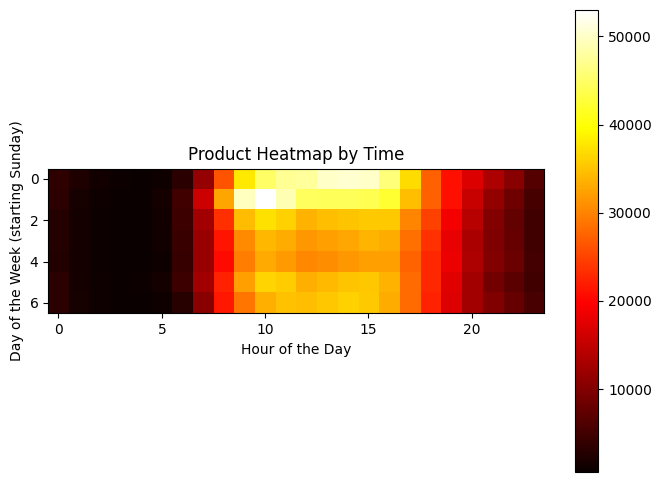

In [ ]:
time_heatmap_all(b_time_count)

In [ ]:
time_heatmap_product("Tooth Brush")

Product does not exist.


2109      2110
7888      7889
9241      9242
10943    10944
13175    13176
24851    24852
29258    29259
30556    30557
37066    37067
39275    39276
Name: product_id, dtype: int64

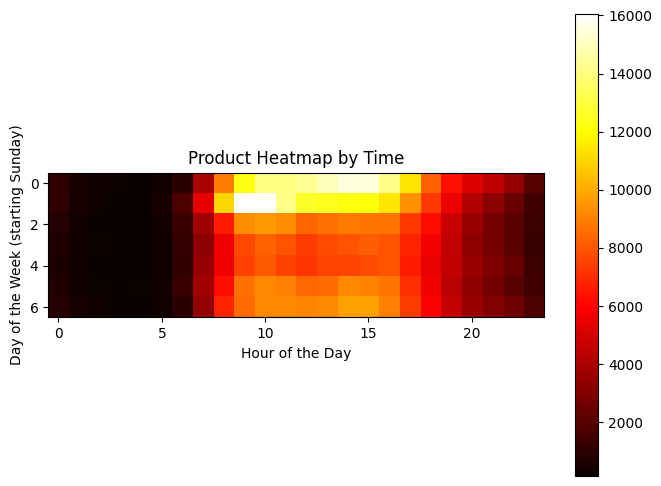

In [ ]:
time_heatmap_approximate_product("Banana", aisle_name="fresh fruits", 1)

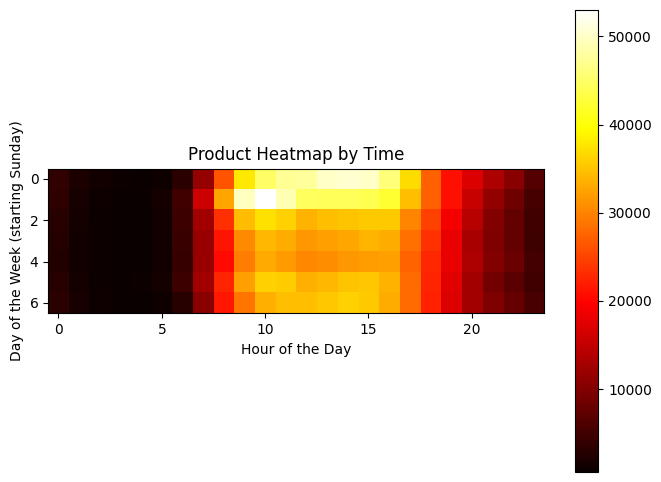

In [ ]:
time_heatmap_all()

68          69
196        197
231        232
521        522
699        700
         ...  
49360    49361
49422    49423
49462    49463
49535    49536
49621    49622
Name: product_id, Length: 787, dtype: int64

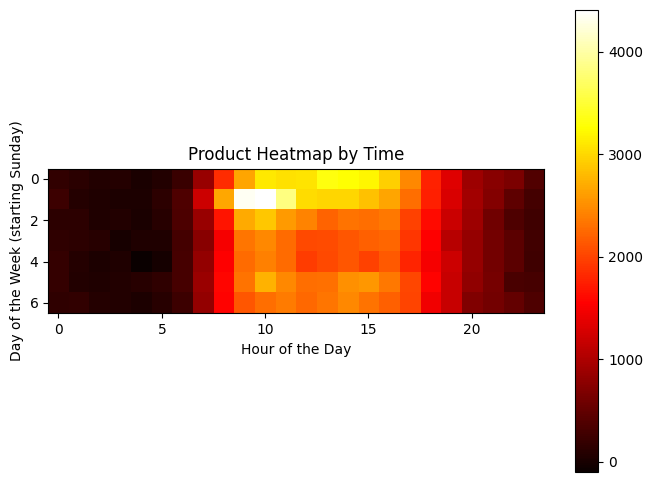

In [ ]:
time_heatmap_approximate_product("Coffee", b_time_count)

In [ ]:
np.sum(orders_df["days_since_prior_order"])/len(orders_df)

10.44487900468945

3421083

In [ ]:
sum(orders_df["days_since_prior_order"])

nan

In [ ]:
def top_products_by_department(department_name, quantity):

  id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]

  df = products_df.query(f"department_id == {id}").sort_values(by=["noised_relative_freq"], ascending=False).head(quantity)

  plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
  plt.bar(df['product_name'], df["noised_relative_freq"], color='blue')


  # Adding labels and title
  plt.xlabel('Product')
  plt.ylabel('Relative Frequency')
  plt.title(f'Most Bought Products in {department_name}')

  plt.xticks(fontsize=8)

# Show plot

In [ ]:
def min_top_products_by_department(department_name, quantity):

  id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]

  df = products_df.query(f"department_id == {id}").sort_values(by=["relative_freq"], ascending=False).head(quantity)

  return df

min_top_products_by_department("produce", 10)

,product_id,product_name,aisle_id,department_id,count,reordered_count,reordered_rate,relative_freq,noised_reordered_rate,noised_relative_freq
24851,24852,Banana,24,4,472565.0,398609.0,0.843501,0.014570,0.843725,0.015048
13175,13176,Bag of Organic Bananas,24,4,379450.0,315913.0,0.832555,0.011699,0.832710,0.013699
21136,21137,Organic Strawberries,24,4,264683.0,205845.0,0.777704,0.008161,0.777787,0.008123
21902,21903,Organic Baby Spinach,123,4,241921.0,186884.0,0.772500,0.007459,0.771202,0.007390
47208,47209,Organic Hass Avocado,24,4,213584.0,170131.0,0.796553,0.006585,0.796685,0.002788
47765,47766,Organic Avocado,24,4,176815.0,134044.0,0.758103,0.005451,0.758198,0.006121
47625,47626,Large Lemon,24,4,152657.0,106255.0,0.696038,0.004707,0.697424,0.004172
16796,16797,Strawberries,24,4,142951.0,99802.0,0.698155,0.004407,0.697749,0.003857
26208,26209,Limes,24,4,140627.0,95768.0,0.681007,0.004336,0.680798,0.004788
27965,27966,Organic Raspberries,123,4,137057.0,105409.0,0.769089,0.004226,0.767670,0.005222


In [ ]:

dep = list(departments_df.sort_values(by=['noised_reordered_rate'], ascending=False).head(5)["department"])


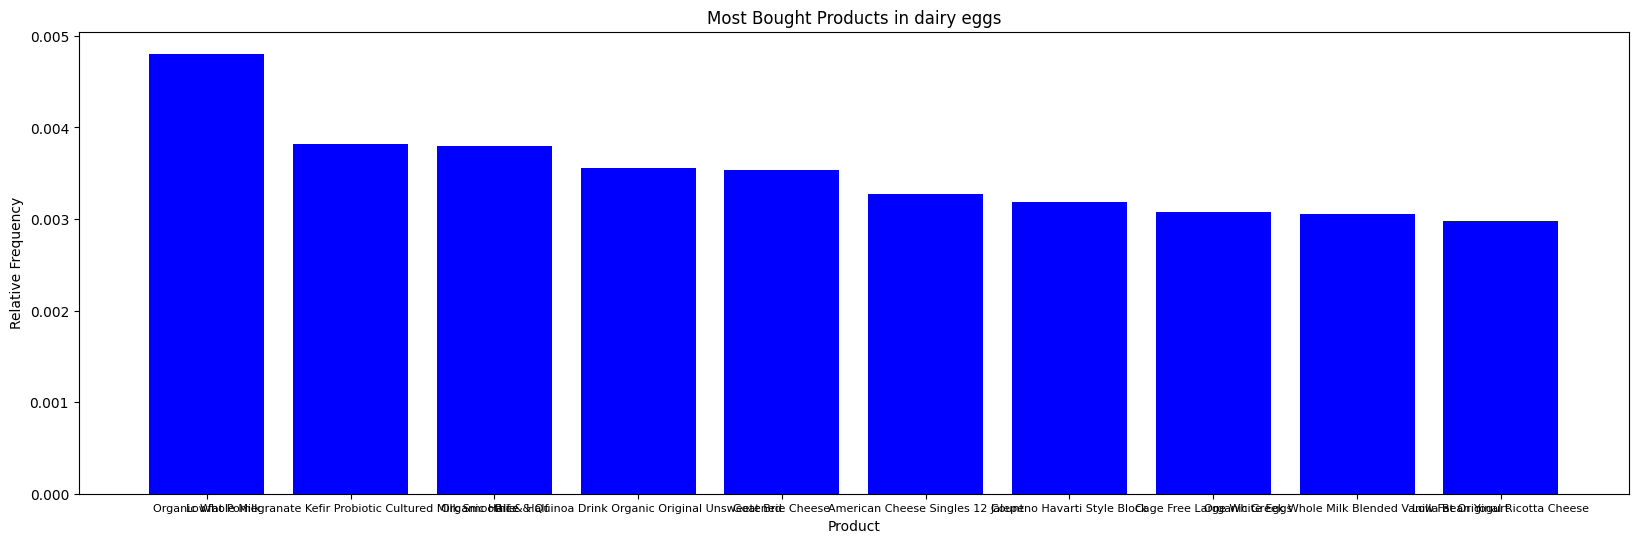

In [ ]:
top_products_by_department(dep[0], 10)

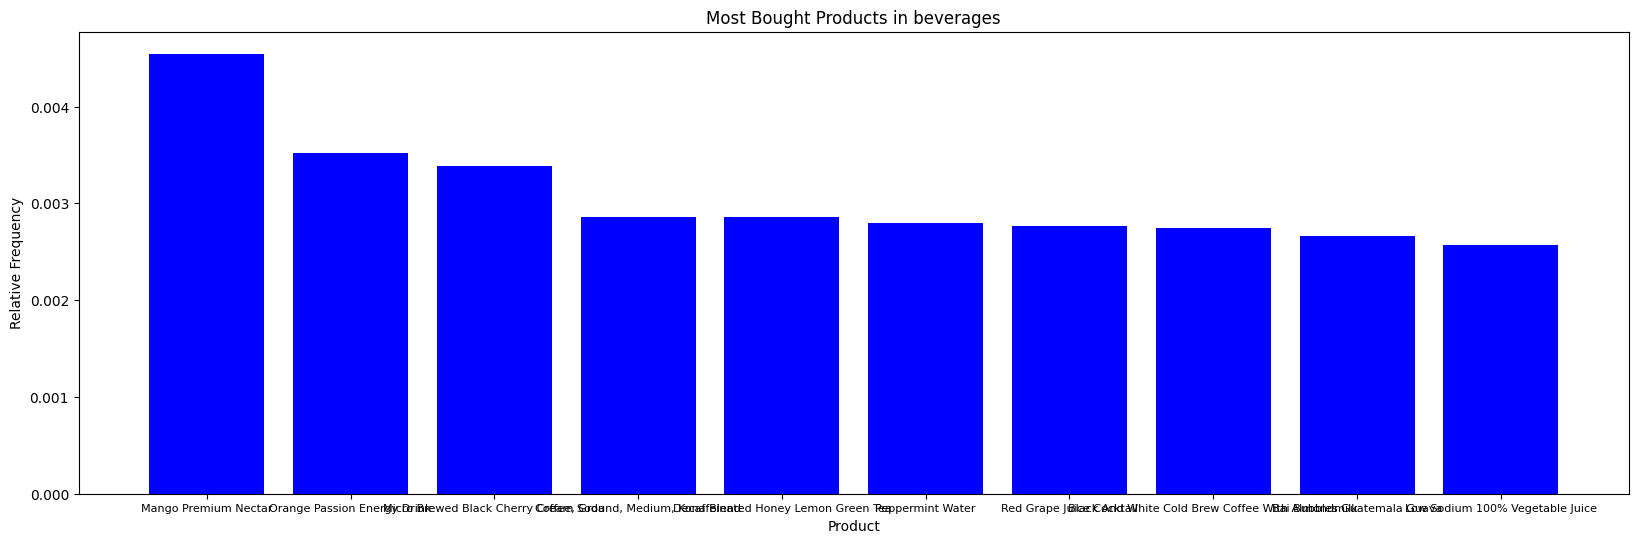

In [ ]:
top_products_by_department(dep[1], 10)

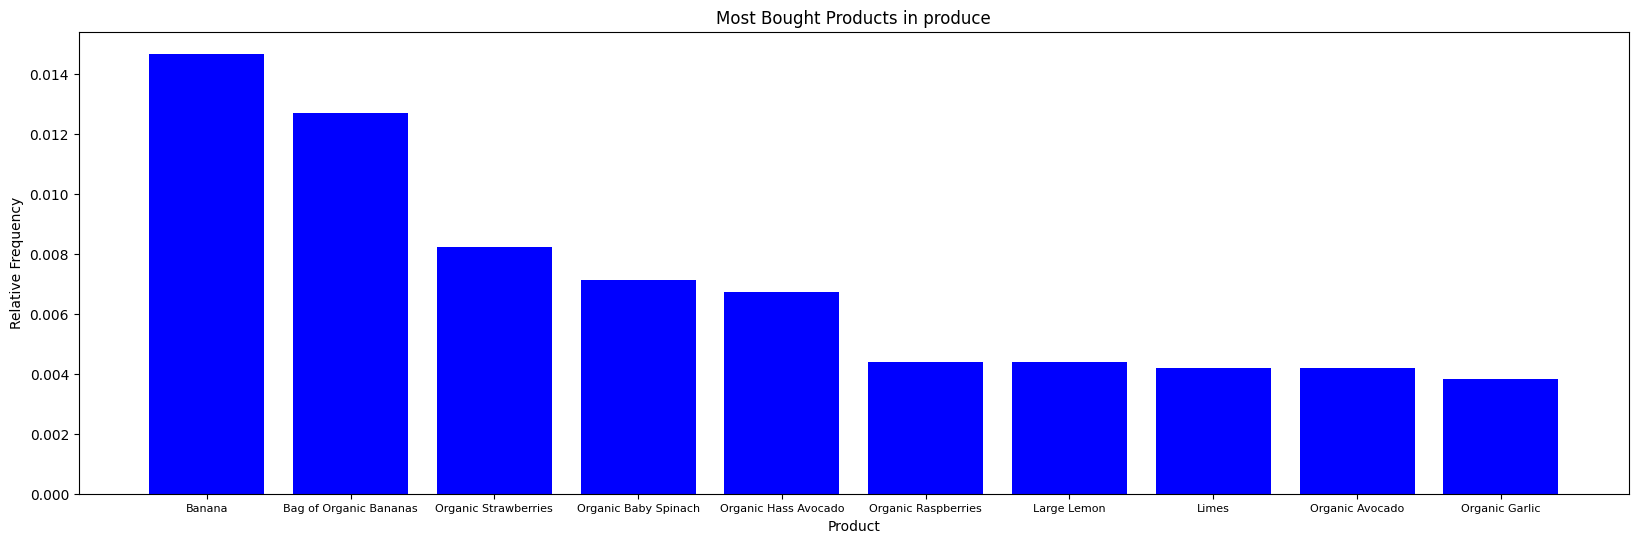

In [ ]:
top_products_by_department(dep[2], 10)

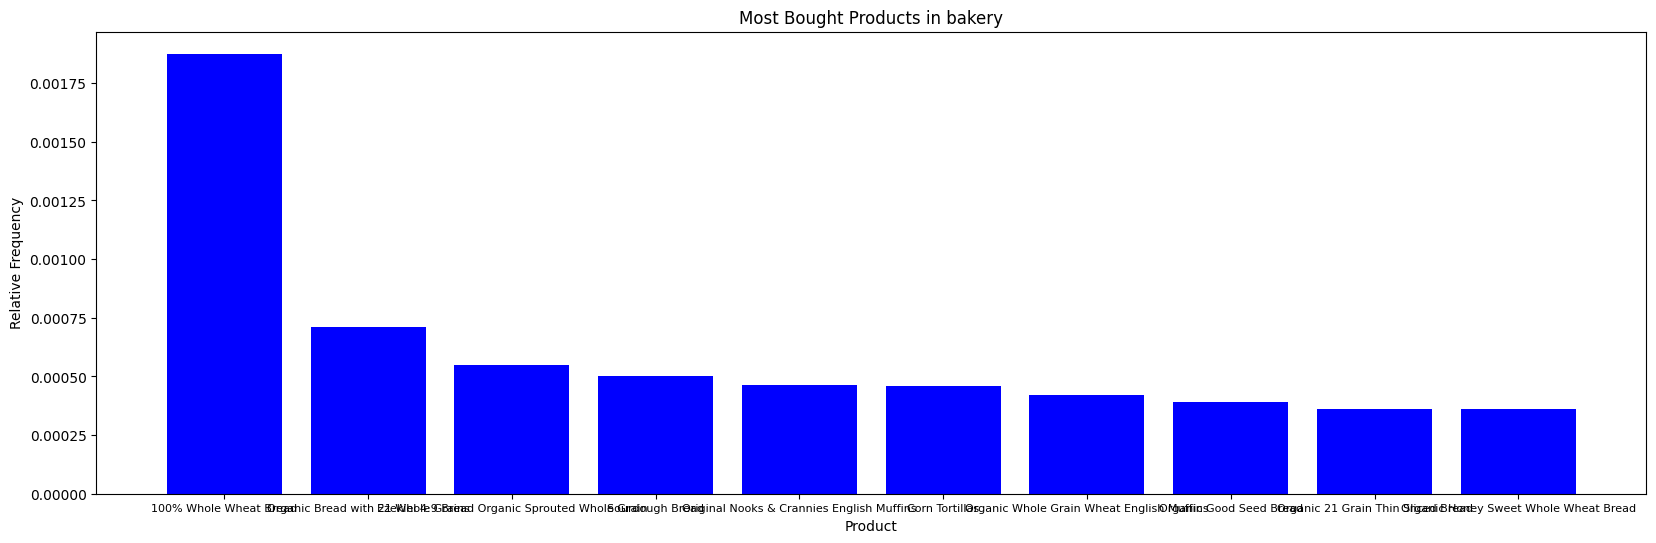

In [ ]:
top_products_by_department(dep[3], 10)

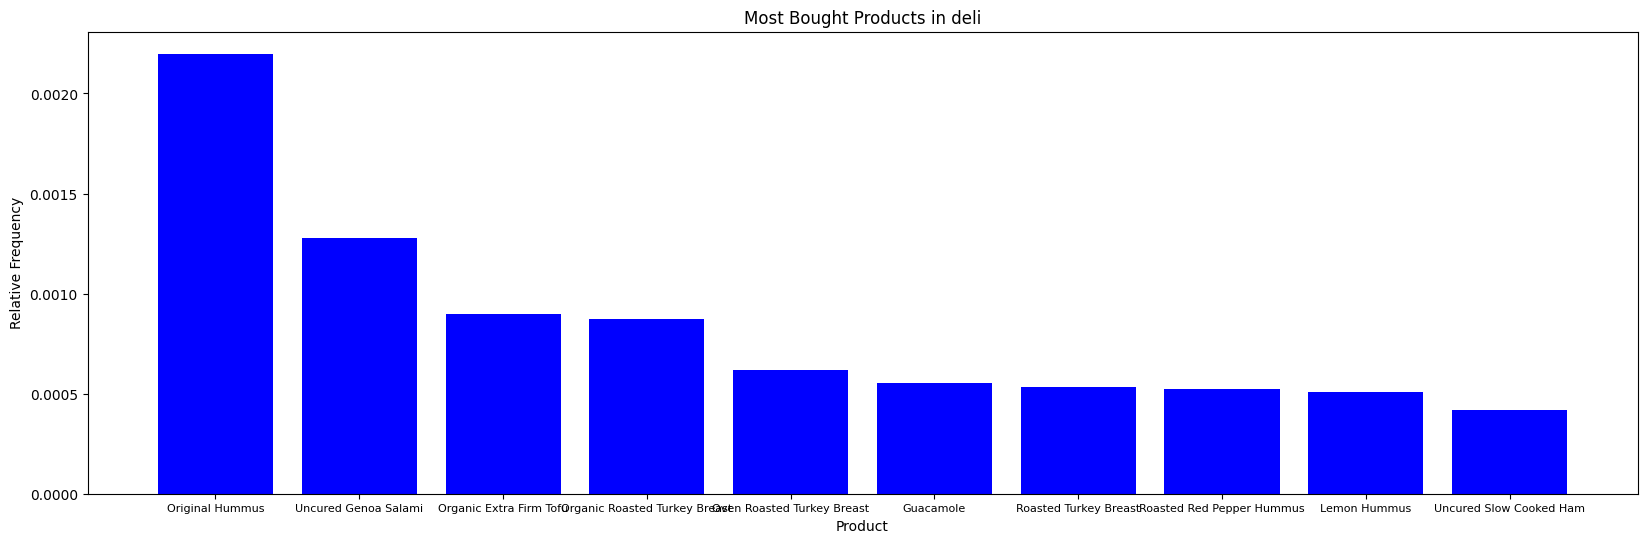

In [ ]:
top_products_by_department(dep[4], 10)

In [ ]:
basket_sizes = order_products_prior_df['order_id'].value_counts()
noised_basket_sizes = add_noise_to_array(basket_sizes, b_bins)

Text(0.5, 1.0, 'Basket size')

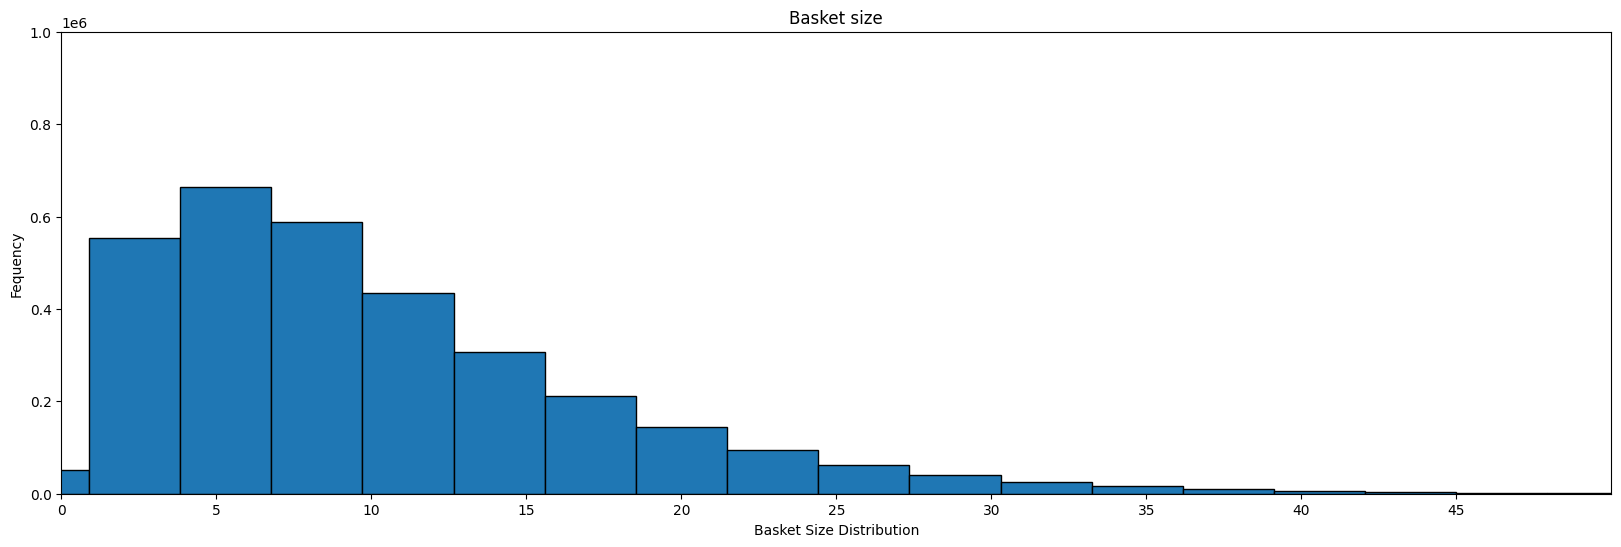

In [ ]:
plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
plt.hist(noised_basket_sizes, bins=50, edgecolor='black')

plt.ylim(0, 1000000)
plt.xlim(0, 50)

plt.xticks(np.arange(0, 50, 5))

# Adding labels and title
plt.xlabel('Basket Size Distribution')
plt.ylabel('Fequency')
plt.title('Basket size')

In [ ]:
np.median(basket_sizes)

8.0

In [ ]:
np.average(basket_sizes)

10.088883421247614

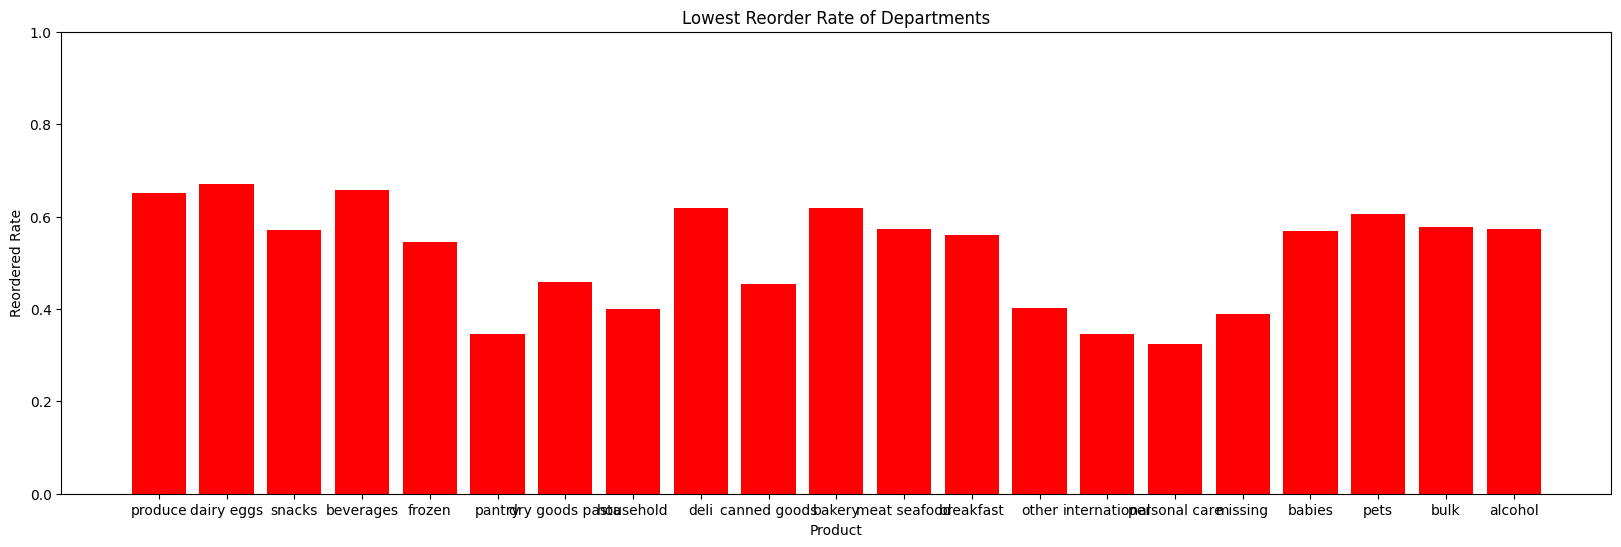

In [ ]:

df1 = departments_df.sort_values(by=['noised_reordered_rate'], ascending=True).head(12)

plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
plt.bar(df['department'], df['noised_reordered_rate'], color='red')

plt.ylim(0, 1)

# Adding labels and title
plt.xlabel('Product')
plt.ylabel('Reordered Rate')
plt.title('Lowest Reorder Rate of Departments')

# Show plot
plt.show()